In [65]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


- $ m(x) = E[f(x)],
k(x, x
0
) = E[(f(x) − m(x))(f(x
0
) − m(x
0
))],$
- $
 f(x) ∼ GP
m(x), k(x, x
0
)
$
. 

In [220]:
function_one = lambda x: x**2
function_two = lambda x: np.log(x)**2

In [223]:
sp.integrate.quad(function_one,1,100)


(333333.0, 3.700739714673773e-09)

In [380]:
first = sp.integrate.quad(function_one,1,100)[0]
second = sp.integrate.quad(function_one,1,100)[1]
function_one_pdf = lambda x: function_one(x) / (first - second)

In [382]:
function_two_pdf = lambda x: function_two(x) / sp.integrate.simps(function_two(range(1,100)),range(1,100))

In [383]:
sp.integrate.simps(function_two_pdf(range(1,100)) ,range(1,100)) # this is a pdf!

1.0

In [384]:
sum([function_one_pdf(i) for i in range(1,100)])# this is a pdf!

0.98505098505099598

In [385]:
mean_function = lambda x: function_one_pdf(x)*function_one(x)+function_two_pdf(x)*function_two(x)
mean_function(2)

0.00021568770285579944

In [386]:
covariance_function = lambda x,x_: function_one_pdf(x)*(function_one(x) - mean_function(x) )* \
                        function_two_pdf(x_)*(function_two(x_)-mean_function(x_))

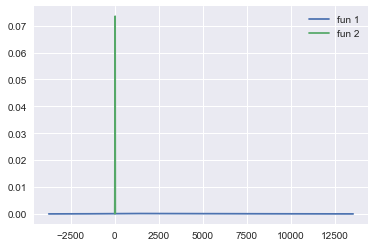

In [387]:
sns.kdeplot(np.array([function_one(i) for i in range(1,100)]),label='fun 1')
sns.kdeplot(function_two(range(1,100)) , label='fun 2')
plt.legend()

In [388]:
covariance_function(2.4,2)

1.6681421473598714e-08

In [389]:
# normal distribution to combine our model parameters
gp = lambda x,x_ : (mean_function(x),covariance_function(x,x_))

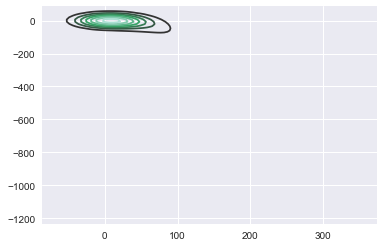

In [390]:
sns.kdeplot(np.array([gp(i,i) for i in range(1,100)]))

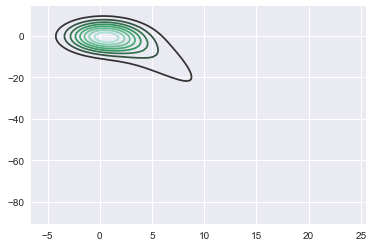

In [391]:
sns.kdeplot(np.array([gp(i,x) for i,x in zip(range(1,100),range(50,100))]))

# Gaussian  Normal Distirbution

- $ cov
f(xp), f(xq)

= k(xp, xq) = exp
−
1
2
|xp − xq|
2

. $
- $f∗ ∼ N
0, K(X∗, X∗)

, $

In [280]:
cov_normal = lambda x,x_ : np.exp(-.5*abs(x - x_)**2)

In [288]:
gaussian_vector = lambda x,x_ : sp.stats.norm(0,cov_normal(x,x_)).rvs()

(-5, 5)

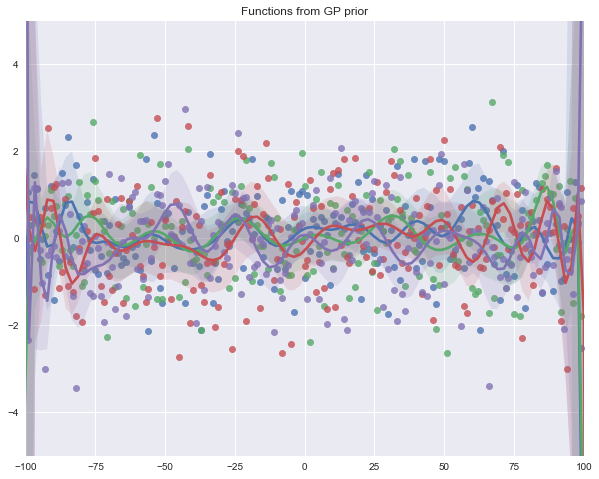

In [399]:

plt.figure(figsize=(10,8))
plt.title('Functions from GP prior')
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=32)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=25)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order = 27)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]), order = 31)
plt.xlim(-100,100)
plt.ylim(-5,5)

## Noise free predictive distribution

$f∗|X∗, X,f ∼ N
K(X∗, X)K(X, X)
−1
f,
K(X∗, X∗) − K(X∗, X)K(X, X)
−1K(X, X∗)
$

Squarred Exponential =

- $exp
−
1
2
|xp − xq|
2

.$

In [640]:
squarred_exp_cv = lambda x_train,x_test : np.exp(-.5*abs(x_train - x_test)**2)

In [641]:
training = range(-100,100)
test = range(-200,100)
cov_training_training  = np.array([[cov_normal(x_,x_) for x_ in range(-100,100)] for _ in range(-100,100)])
cov_training_test = np.array([[cov_normal(x_,x) for (x_,x) in zip(range(-100,100),range(-200,100))]
                              for _ in range(-100,100)])

# Noisy predictive distribution
- training points = (-100,100)
- test points = (-200,300,400) # only two

In [215]:
training_funcion  =  lambda x: x**4

In [291]:
train_x = np.linspace(-10,10,100) # x values
test_x = np.linspace(7,12,3)
train_y = np.array(list(map(training_funcion,train_x))).reshape(-1,1) # columns vector
train_y_var = np.var(train_y)

In [292]:
list(test_x)

[7.0, 9.5, 12.0]

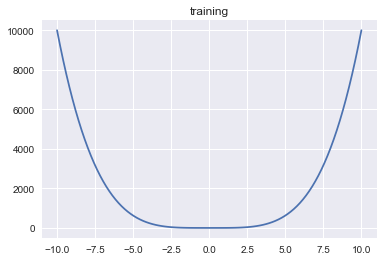

In [293]:
plt.plot(train_x,train_y)
plt.title('training');

In [294]:
train_y_var

7694924.0545385135

In [295]:

#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*abs(x_ - x)**2)


In [296]:
# find the covariance between the data points
cov_test_train_matrix = np.zeros((len(test_x),len(train_x)))
cov_test_test_matrix = np.zeros((len(test_x),len(test_x)))
cov_train_test_matrix = np.zeros((len(train_x),len(test_x)))
cov_train_train_matrix = np.zeros((len(train_x),len(train_x))) # assume noisy prediction
                                 

for idx_test, x_test in enumerate(test_x):
    for idx_train, x_train in enumerate(train_x):
        cov_test_train_matrix[idx_test,idx_train] = squarred_exponential_kernel(x_test,x_train)

for idx_test1, x_test1 in enumerate(test_x):
    for idx_test2, x_test2 in enumerate(test_x):
        cov_test_test_matrix[idx_test1,idx_test2]= squarred_exponential_kernel(x_test1,x_test2)
                                 
for idx_train, x_train in enumerate(train_x):
    for idx_test, x_test in enumerate(test_x):
        cov_train_test_matrix[idx_train,idx_test] = squarred_exponential_kernel(x_train,x_test)

for idx_train1, x_train1 in enumerate(train_x):
    for idx_train2, x_train2 in enumerate(train_x):
        cov_train_train_matrix[idx_train1,idx_train2] = squarred_exponential_kernel(x_train1,x_train2)
        
 

In [297]:
 # assume noisy predictions so teh covariance between the training points (train,train) has
# to add the variance of the y values
training_y_cov_matrix = np.zeros((len(cov_train_train_matrix),len(cov_train_train_matrix)), int)
np.fill_diagonal(training_y_cov_matrix, train_y_var)

In [298]:
cov_train_train_matrix = cov_train_train_matrix  + training_y_cov_matrix 

In [299]:
expected_mean_noisy_predictions = cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix) @train_y 

In [300]:
expected_mean_noisy_predictions  # 2 test points, 2 predicted means

array([[ 0.00433258],
       [ 0.00810993],
       [ 0.00041235]])

In [301]:
expected_cov_noisy_predictions = cov_test_test_matrix - cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix)\
                    @ cov_train_test_matrix

In [302]:
expected_cov_noisy_predictions.shape # 2 x 2 for the test points

(3, 3)

### Now, define a normal distribution given the parameters above

In [303]:
predictive_normal_noisy = sp.stats.multivariate_normal(expected_mean_noisy_predictions.ravel(),
                                                       expected_cov_noisy_predictions  )

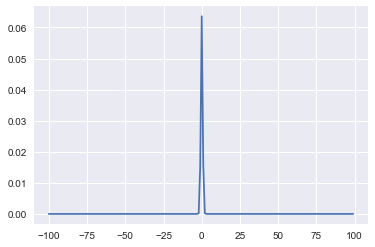

In [304]:
plt.plot(range(-100,100),[predictive_normal_noisy.pdf(i) for i in range(-100,100)])

ValueError: third arg must be a format string

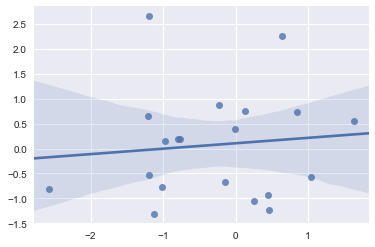

In [305]:
# random draws from the distrbution's posterior predictive
predicted_points = predictive_normal_noisy.rvs(20).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points
sns.regplot(*predicted_points,order=1)

#sns.regplot(*predicted_points,order=2)
plt.plot(*np.array(sorted(predicted_points.T, key=lambda x: x[0])).T) # plot them in order of smallest to largest
plt.xlim(-5,5)
plt.ylim(-2,2);
plt.title('Posterior Prediction')

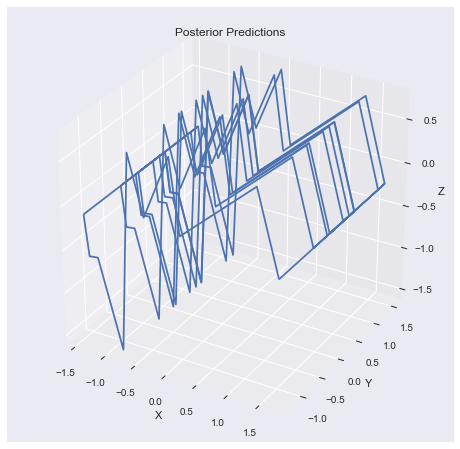

In [324]:


predicted_points = predictive_normal_noisy.rvs(10).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

#t = np.linspace(-3, 2, 31)
#s = np.linspace(-3, 2, 31)
x = predicted_points[0]
y = predicted_points[1]
z = predicted_points[2]

X, Y = np.meshgrid(x,y)
Z  = np.meshgrid(z,y)

ax.plot_wireframe(X,Y,Z[0],ccount=1, rcount=10)
#ax.plot_wireframe(X,Y,Z[1],ccount=1)
#ax.plot_surface(x,y,z, cmap=cm.jet, rstride=1, cstride=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Posterior Predictions')

plt.show()

In [307]:


x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])
print(xy)
mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z =predictive_normal_noisy .pdf(xy)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)
plt.title('PDF of multivariate gaussian process')
plt.show()

[[-5.         -5.        ]
 [-5.         -4.79591837]
 [-5.         -4.59183673]
 ..., 
 [ 5.          4.59183673]
 [ 5.          4.79591837]
 [ 5.          5.        ]]


ValueError: operands could not be broadcast together with shapes (2500,2) (3,) 